In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

In [3]:
# set some seaborn aesthetics
sbn.set_palette("Set1")

In [4]:
# initialize random seed for reproducibility
np.random.seed(20160330)

# One-way ANOVA, general setup

We'll starting with simulating data for a one-way ANOVA, under the null hypothesis.

In this simulation we'll simulate four groups, all drawn from the same underlying distribution: $N(\mu=0,\sigma=1)$.

In [5]:
## simulate one way ANOVA under the null hypothesis of no 
## difference in group means

groupmeans = [0, 0, 0, 0]
k = len(groupmeans) # number of groups
groupstds = [1] * k  # standard deviations equal across groups
n = 25 # sample size

# generate samples
samples = [stats.norm.rvs(loc=i, scale=j, size = n) for (i,j) in zip(groupmeans,groupstds)]

### Illustrate sample distributions and group means

We then draw the simulated data, showing the group distributions on the left and the distribution of group means on the right.

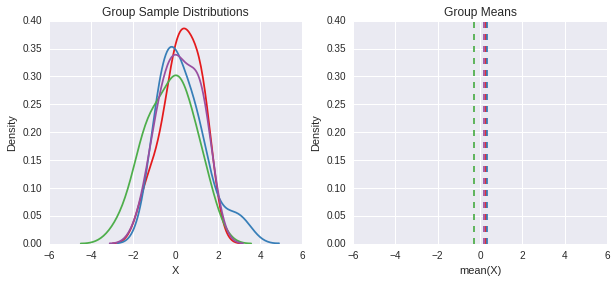

In [6]:
# draw a figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
clrs = sbn.color_palette("Set1", n_colors=k)

for i, sample in enumerate(samples):
    sbn.kdeplot(sample, color=clrs[i], ax=ax1)
ax1_ymax = ax1.get_ylim()[1]

for i, sample in enumerate(samples):
    ax2.vlines(np.mean(sample), 0, ax1_ymax, linestyle="dashed", color=clrs[i])
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(ax1.get_ylim())    

ax1.set_title("Group Sample Distributions")
ax2.set_title("Group Means")

ax1.set_xlabel("X")
ax1.set_ylabel("Density")

ax2.set_xlabel("mean(X)")
ax2.set_ylabel("Density")
pass

## F-statistic

We calculate an F-statistic, which is the ratio of the "between group" variance to the "within group" variance.  The calculation below is appropriate when all the group sizes are the same.

In [7]:
# Between-group and within-group estimates of variance
sample_group_means = [np.mean(s) for s in samples]
sample_group_var = [np.var(s, ddof=1) for s in samples]

Vbtw = n * np.var(sample_group_means, ddof=1)
Vwin = np.mean(sample_group_var)
Fstat = Vbtw/Vwin

print("Between group estimate of population variance:", Vbtw)
print("Within group estimate of population variance:", Vwin)
print("Fstat = Vbtw/Vwin = ", Fstat)

Between group estimate of population variance: 2.00998462641
Within group estimate of population variance: 1.00249643886
Fstat = Vbtw/Vwin =  2.00497931812


# Simulating the sampling distribution of the F-test statistic

To understand how surprising our observed data is, relative to what we would expect under the null hypothesis, we need to understand the sampling distribution of the F-statistic.  Here we use simulation to estimate this sampling distribution.

In [8]:
# now carry out many such simulations to estimate the sampling distristribution
# of our F-test statistic

groupmeans = [0, 0, 0, 0]
k = len(groupmeans) # number of groups
groupstds = [1] * k  # standard deviations equal across groups
n = 25 # sample size

nsims = 1000
Fstats = []
for sim in range(nsims):
    samples = [stats.norm.rvs(loc=i, scale=j, size = n) for (i,j) in zip(groupmeans,groupstds)]
    sample_group_means = [np.mean(s) for s in samples]
    sample_group_var = [np.var(s, ddof=1) for s in samples]
    Vbtw = n * np.var(sample_group_means, ddof=1)
    Vwin = np.mean(sample_group_var)
    Fstat = Vbtw/Vwin
    Fstats.append(Fstat)
    
Fstats = np.array(Fstats)


## Draw a figure to compare our simulated sampling distribution of the F-statistic to the theoretical expectation

Let's create a plot comparing our simulated sampling distribution to the theoretical sampling distribution determined analytically.  As we see below they compare well.

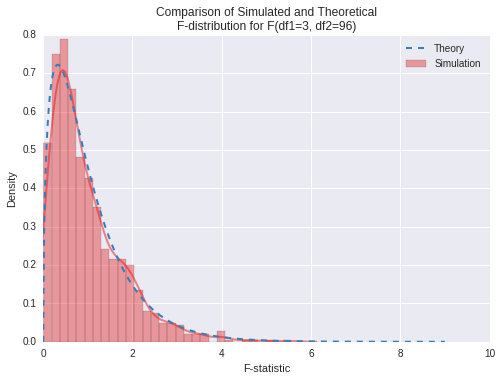

In [10]:
fig, ax = plt.subplots()
sbn.distplot(Fstats, ax=ax, label="Simulation",
             kde_kws=dict(alpha=0.5, linewidth=2))

# plot the theoretical F-distribution for
# corresponding degrees of freedom
df1 = k - 1
df2 = n*k - k
x = np.linspace(0,9,500)
Ftheory = stats.f.pdf(x, df1, df2)
plt.plot(x,Ftheory, linestyle='dashed', linewidth=2, label="Theory")

# axes, legends, title
ax.set_xlim(0, )
ax.set_xlabel("F-statistic")
ax.set_ylabel("Density")
ax.legend()
title = \
"""Comparison of Simulated and Theoretical
F-distribution for F(df1={}, df2={})"""
ax.set_title(title.format(df1, df2))

pass

## Determining signficance thresholds

To determine whether we would reject the null hypothesis for an observed value of the F-statistic we need to calculate the appropriate cutoff value for a given significance threshold, $\alpha$.

Here we consider the standard signficiance threshold $\alpha$ = 0.05.

The α =0.05 significance threshold is: 2.69939259755


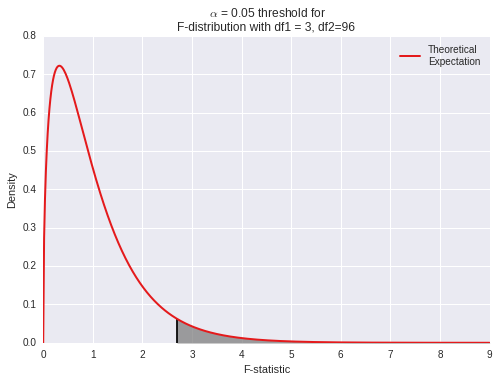

In [11]:
# draw F distribution
x = np.linspace(0,9,500)
Ftheory = stats.f.pdf(x, df1, df2)
plt.plot(x, Ftheory, linestyle='solid', linewidth=2, label="Theoretical\nExpectation")

# draw vertical line at threshold
threshold = stats.f.ppf(0.95, df1, df2)
plt.vlines(threshold, 0, stats.f.pdf(threshold, df1, df2), linestyle='solid')

# shade area under curve to right of threshold
areax = np.linspace(threshold, 9, 250)
plt.fill_between(areax, stats.f.pdf(areax, df1, df2), color='gray', alpha=0.75)

# axes, legends, title
plt.xlim(0, )
plt.xlabel("F-statistic")
plt.ylabel("Density")
plt.legend()
title = \
r""" $\alpha$ = 0.05 threshold for 
F-distribution with df1 = {}, df2={}"""
plt.title(title.format(df1, df2))

print("The α =0.05 significance threshold is:", threshold)

pass


Note that the F-distribution above is specific to the particular degrees of freedom. We would typically refer to that distribution as $F_{3,96}$.  In this case, for $\alpha=0.5$, we would reject the null hypothesis if the observed value of the F-statistic was greater than 2.70.

## Simulation where $H_A$ holds

As we've done in previous cases, it's informative to simulate the situation where the null hypothesis is false (i.e. the alternative hypothesis $H_A$ is true).  

Here we simulate the case where one of the four groups is drawn from a normal distribution with a mean that is different from the other three groups -- $N(\mu=1, \sigma=1)$ rather than $N(\mu=0, \sigma=1)$.

In [12]:
# now simulate case where one of the group means is different

groupmeans = [0, 0, 0, 1]
k = len(groupmeans) # number of groups
groupstds = [1] * k  # standard deviations equal across groups
n = 25 # sample size

nsims = 1000
Fstats = []
for sim in range(nsims):
    samples = [stats.norm.rvs(loc=i, scale=j, size = n) for (i,j) in zip(groupmeans,groupstds)]
    sample_group_means = [np.mean(s) for s in samples]
    sample_group_var = [np.var(s, ddof=1) for s in samples]
    Vbtw = n * np.var(sample_group_means, ddof=1)
    Vwin = np.mean(sample_group_var)
    Fstat = Vbtw/Vwin
    Fstats.append(Fstat)
    
Fstats = np.array(Fstats)


We then plot the distribution of the F-statistic under this specific $H_A$ versus the distribution of F under the null hypothesis.

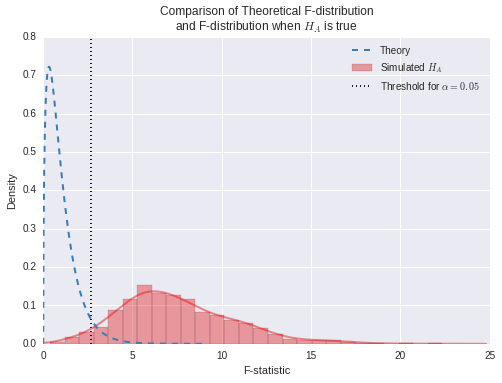

In [16]:
fig, ax = plt.subplots()
sbn.distplot(Fstats, ax=ax, label="Simulated $H_A$",
             kde_kws=dict(alpha=0.5, linewidth=2))

# plot the theoretical F-distribution for
# corresponding degrees of freedom
df1 = k - 1
df2 = n*k - k
x = np.linspace(0,9,500)
Ftheory = stats.f.pdf(x, df1, df2)
plt.plot(x,Ftheory, linestyle='dashed', linewidth=2, label="Theory")

ymin, ymax = ax.get_ylim()
# Draw threshold alpha = 0.05
ax.vlines(stats.f.ppf(0.95, df1, df2), 0, ymax, linestyle='dotted', 
          color='k', label=r"Threshold for $\alpha=0.05$")

# axes, legends, title
ax.set_xlim(0, )
ax.set_ylim(0, ymax)
ax.set_xlabel("F-statistic")
ax.set_ylabel("Density")
ax.legend()
title = \
"""Comparison of Theoretical F-distribution
and F-distribution when $H_A$ is true"""
ax.set_title(title.format(df1, df2))

pass

The fracion of cases that are false-negatives (i.e. we fail to reject the null hypothesis when the alternative hypothesis is true) is $\beta$. This is the fraction of the red distribution to the left of the $\alpha$ treshold.  The power of our test *under this particular scenario* is 1-$\beta$.